# Deteksi Emosi Karyawan Berbasis Wajah Menggunakan DenseNet-169

**Mata Kuliah**: Pengolahan Citra Digital dan Visi Komputer  
**Anggota** : Muhammad Makarim (225150207111122), Rakha Alif Athallah (2225150207111050)

## Tujuan
Mendeteksi emosi karyawan dari citra wajah menggunakan metode kombinasi:
1. Konversi Ruang Warna
2. Peningkatan Kualitas Citra (Histogram Equalization / CLAHE)
3. Pengenalan Wajah (Haarcascade) + Klasifikasi Emosi dengan CNN (DenseNet-169, transfer learning)

Output utama:
- Model klasifikasi emosi berbasis DenseNet-169
- Evaluasi performa (akurasi, F1-score, confusion matrix)
- Visualisasi Grad-CAM untuk interpretasi fitur wajah


# **Import Library dan Dataset**

In [1]:
!pip install timm torchmetrics grad-cam gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.7 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=e3efc2a186f99e8ce322424127e1a31fd73f787fc5340f865a8c8f17089715c9
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import timm
import torchmetrics
from sklearn.metrics import confusion_matrix, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

IM_SIZE = 224
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 20

GDRIVE_DATASET_URL = "https://drive.google.com/drive/folders/1cOHBFFUHI_acdK2KTMgsxz2sTQ8n48Ai?usp=drive_link"

import gdown
RAW_DATA_DIR = "/content/dataset_raw"
EXTRACT_DIR = "/content/dataset_faces"
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)

print("Mengunduh dataset dari Google Drive...")
gdown.download_folder(GDRIVE_DATASET_URL, output=RAW_DATA_DIR, quiet=False, use_cookies=False)

zip_files = glob(os.path.join(RAW_DATA_DIR, "*.zip"))
if len(zip_files) == 0:
    raise FileNotFoundError(f"Tidak ditemukan file .zip di {RAW_DATA_DIR}. Pastikan folder GDrive berisi dataset .zip.")

zip_path = zip_files[0]
print("Zip dataset ditemukan:", zip_path)

print("Mengekstrak zip...")
!unzip -q "{zip_path}" -d "{EXTRACT_DIR}"
print("Selesai ekstrak.")

DATASET_ROOT = EXTRACT_DIR

print("DATASET_ROOT:", DATASET_ROOT)
print("Isi DATASET_ROOT:")
!ls "{DATASET_ROOT}"

Mounted at /content/drive
Device: cuda
Mengunduh dataset dari Google Drive...


Retrieving folder contents


Processing file 1k3uyWnjCmS1FVuRa0tp2kjDuap63_OJk dataset_emotion.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1k3uyWnjCmS1FVuRa0tp2kjDuap63_OJk
From (redirected): https://drive.google.com/uc?id=1k3uyWnjCmS1FVuRa0tp2kjDuap63_OJk&confirm=t&uuid=dc1efce5-6fcf-4c2b-8478-a6fc2d9803ed
To: /content/dataset_raw/dataset_emotion.zip
100%|██████████| 130M/130M [00:01<00:00, 84.2MB/s]
Download completed


Zip dataset ditemukan: /content/dataset_raw/dataset_emotion.zip
Mengekstrak zip...
Selesai ekstrak.
DATASET_ROOT: /content/dataset_faces
Isi DATASET_ROOT:
test  train  val


# **Eksplorasi Dataset & Struktur Folder**

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
=== TRAIN ===
{'angry': 4289, 'disgust': 4289, 'fear': 4289, 'happy': 4289, 'neutral': 4289, 'sad': 4289, 'surprise': 4289}
=== VAL ===
{'angry': 1072, 'disgust': 1072, 'fear': 1072, 'happy': 1072, 'neutral': 1072, 'sad': 1072, 'surprise': 1072}
=== TEST ===
{'angry': 595, 'disgust': 595, 'fear': 595, 'happy': 595, 'neutral': 595, 'sad': 595, 'surprise': 595}


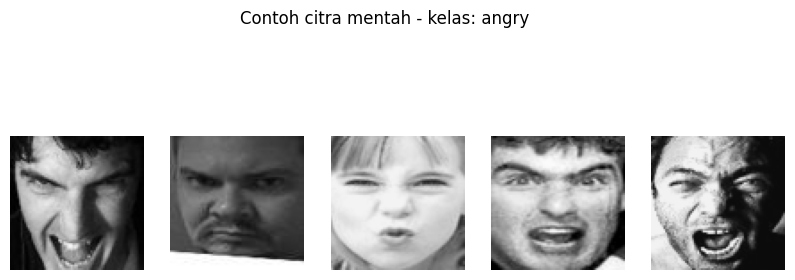

In [3]:
# 2.1 Cek class names dari folder train
train_dir = os.path.join(DATASET_ROOT, "train")
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

# Mapping nama kelas -> index
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Mapping:", class_to_idx)

# 2.2 Hitung jumlah gambar per kelas (train/val/test)
def count_images_per_class(split):
    split_dir = os.path.join(DATASET_ROOT, split)
    counts = {}
    for cls in class_names:
        folder = os.path.join(split_dir, cls)
        counts[cls] = len(glob(os.path.join(folder, "*.*")))
    return counts

for split in ["train", "val", "test"]:
    print(f"=== {split.upper()} ===")
    print(count_images_per_class(split))

# 2.3 Tampilkan beberapa contoh citra mentah (belum preprocessing)
example_paths = glob(os.path.join(train_dir, class_names[0], "*.*"))[:5]

plt.figure(figsize=(10, 4))
for i, p in enumerate(example_paths):
    img = cv2.imread(p)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(example_paths), i+1)
    plt.imshow(img_rgb)
    plt.axis("off")
plt.suptitle(f"Contoh citra mentah - kelas: {class_names[0]}")
plt.show()


# **Pre-processing & Face Detection**

## **Load Haarcascade dan definisikan fungsi CLAHE**

In [4]:
# 3.1 Load Haarcascade face detector
haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_path)

# 3.2 Fungsi preprocessing dengan 3 materi:
# - Konversi ruang warna
# - CLAHE
# - Deteksi wajah

def preprocess_and_detect_face(bgr_image, return_bbox=False):
    """
    Input:
        bgr_image: numpy array (BGR, dari cv2.imread)
    Output:
        face_gray_eq: citra wajah hasil CLAHE (grayscale)
        (opsional) bbox: (x, y, w, h)
    """

    # (1) BGR -> GRAY (Konversi ruang warna)
    gray = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

    # (2) CLAHE (Histogram Equalization lokal)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray)

    # (3) Deteksi wajah (Haarcascade)
    faces = face_cascade.detectMultiScale(gray_eq, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
        # fallback: gunakan seluruh citra
        face_roi = gray_eq
        bbox = None
    else:
        # ambil wajah terbesar
        x, y, w, h = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
        face_roi = gray_eq[y:y+h, x:x+w]
        bbox = (x, y, w, h)

    if return_bbox:
        return face_roi, bbox
    else:
        return face_roi

## **Visualisasi sebelum & sesudah preprocessing**

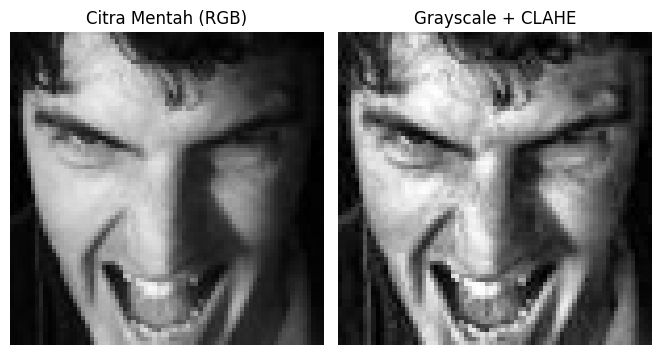

In [5]:
sample_path = example_paths[0]
bgr = cv2.imread(sample_path)
face_roi, bbox = preprocess_and_detect_face(bgr, return_bbox=True)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Citra Mentah (RGB)")
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grayscale + CLAHE")
plt.imshow(face_roi, cmap="gray")
plt.axis("off")

if bbox is not None:
    x, y, w, h = bbox
    bgr_box = bgr.copy()
    cv2.rectangle(bgr_box, (x,y), (x+w, y+h), (0,255,0), 2)
    plt.subplot(1, 3, 3)
    plt.title("Deteksi Wajah (Haarcascade)")
    plt.imshow(cv2.cvtColor(bgr_box, cv2.COLOR_BGR2RGB))
    plt.axis("off")

plt.tight_layout()
plt.show()


# **PyTorch Transform, Dataset, dan DataLoader**

## **Transform PyTorch (Resize + Grayscale→3ch + Normalize)**

In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((IM_SIZE, IM_SIZE)),
    T.Grayscale(num_output_channels=3),  # masih memanfaatkan materi konversi warna
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# **Custom Dataset**

In [8]:
class EmotionFaceDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform

        self.image_paths = []
        self.labels = []

        for cls_name in class_names:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for p in glob(os.path.join(cls_dir, "*.*")):
                self.image_paths.append(p)
                self.labels.append(class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Baca gambar (OpenCV, BGR)
        bgr = cv2.imread(img_path)

        # Pre-processing (3 materi kuliah)
        face_gray_eq = preprocess_and_detect_face(bgr)

        # Konversi ke PIL Image untuk transform torchvision
        pil_img = Image.fromarray(face_gray_eq)

        if self.transform is not None:
            img_tensor = self.transform(pil_img)
        else:
            img_tensor = T.ToTensor()(pil_img)

        return img_tensor, label

# 4.3. DataLoader
train_ds = EmotionFaceDataset(DATASET_ROOT, split="train", transform=transform)
val_ds   = EmotionFaceDataset(DATASET_ROOT, split="val",   transform=transform)
test_ds  = EmotionFaceDataset(DATASET_ROOT, split="test",  transform=transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dl  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=2)

len(train_ds), len(val_ds), len(test_ds)


(30023, 7504, 4165)

# **Visualisasi Data Setelah Pre-processing**

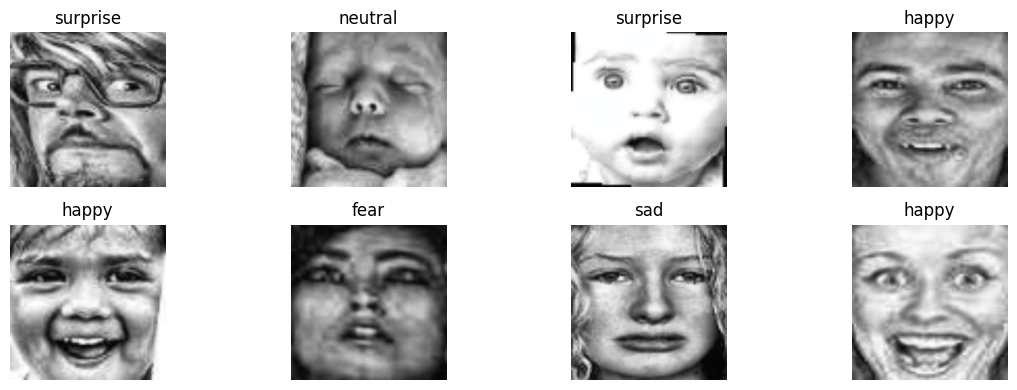

In [9]:
def show_batch(dl, n_images=8):
    imgs, labels = next(iter(dl))
    plt.figure(figsize=(12, 4))
    for i in range(min(n_images, len(imgs))):
        img = imgs[i]
        # denormalize untuk visualisasi
        img_np = img.numpy()
        img_np = np.transpose(img_np, (1, 2, 0))  # C,H,W -> H,W,C
        img_np = img_np * np.array(std) + np.array(mean)
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, n_images//2, i+1)
        plt.imshow(img_np)
        plt.title(idx_to_class[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_dl)

# **Definisi Model DenseNet (Transfer Learning)**

In [10]:
NUM_CLASSES = len(class_names)

def create_densenet_model(num_classes, pretrained=True, freeze_feature_extractor=False):
    model = timm.create_model(
        "densenet169",
        pretrained=pretrained,
        num_classes=num_classes
    )

    if freeze_feature_extractor:
        for name, param in model.named_parameters():
            param.requires_grad = False

        # Hanya head/classifier yang di-train
        for param in model.get_classifier().parameters():
            param.requires_grad = True

    return model.to(device)

model = create_densenet_model(NUM_CLASSES, pretrained=True, freeze_feature_extractor=False)
print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

# **Training Utility (loss, optimizer, metric, loop)**

## **Setup loss, optimizer, metrics, scheduler**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# F1-score macro (torchmetrics)
f1_metric = torchmetrics.F1Score(
    task="multiclass",
    num_classes=NUM_CLASSES,
    average="macro"
).to(device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=2,
    factor=0.5
)


In [13]:
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

## **Fungsi train_epoch & eval_epoch**

In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    f1_metric.reset()

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

        f1_metric.update(preds, labels)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    epoch_f1  = f1_metric.compute().item()

    return epoch_loss, epoch_acc, epoch_f1

def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    f1_metric.reset()

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

            f1_metric.update(preds, labels)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    epoch_f1  = f1_metric.compute().item()

    return epoch_loss, epoch_acc, epoch_f1


## **Main training loop + save best model (ke Drive)**

In [15]:
best_val_f1 = 0.0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": []
}

SAVE_DIR = "/content/drive/MyDrive/PROJECT_EMOSI/models"
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(SAVE_DIR, "densenet169_emosi_best.pth")

for epoch in range(EPOCHS):
    print(f"Epoch [{epoch+1}/{EPOCHS}]")

    train_loss, train_acc, train_f1 = train_one_epoch(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc, val_f1       = eval_one_epoch(model, val_dl, criterion, device)

    scheduler.step(val_loss)
    print(f"Learning rate saat ini: {get_lr(optimizer):.6f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc:  {train_acc:.4f} | Val Acc:  {val_acc:.4f}")
    print(f"Train F1:   {train_f1:.4f} | Val F1:   {val_f1:.4f}")

    # Simpan best model by val_f1
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(">> Best model saved!")

Epoch [1/20]
Learning rate saat ini: 0.000100
Train Loss: 0.7164 | Val Loss: 0.3502
Train Acc:  0.7440 | Val Acc:  0.8786
Train F1:   0.7442 | Val F1:   0.8795
>> Best model saved!
Epoch [2/20]
Learning rate saat ini: 0.000100
Train Loss: 0.2905 | Val Loss: 0.2139
Train Acc:  0.9015 | Val Acc:  0.9294
Train F1:   0.9016 | Val F1:   0.9295
>> Best model saved!
Epoch [3/20]
Learning rate saat ini: 0.000100
Train Loss: 0.1595 | Val Loss: 0.1828
Train Acc:  0.9461 | Val Acc:  0.9378
Train F1:   0.9461 | Val F1:   0.9374
>> Best model saved!
Epoch [4/20]
Learning rate saat ini: 0.000100
Train Loss: 0.1134 | Val Loss: 0.1970
Train Acc:  0.9614 | Val Acc:  0.9360
Train F1:   0.9614 | Val F1:   0.9359
Epoch [5/20]
Learning rate saat ini: 0.000100
Train Loss: 0.0942 | Val Loss: 0.1771
Train Acc:  0.9669 | Val Acc:  0.9431
Train F1:   0.9669 | Val F1:   0.9426
>> Best model saved!
Epoch [6/20]
Learning rate saat ini: 0.000100
Train Loss: 0.0737 | Val Loss: 0.2477
Train Acc:  0.9759 | Val Acc:  0

# **Plot Learning Curves (Loss, Accuracy, F1)**

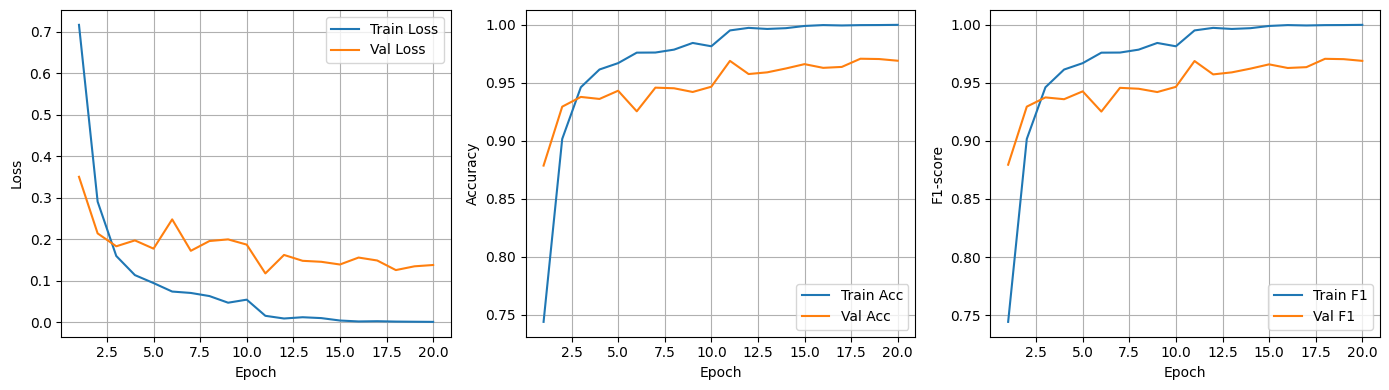

In [16]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14,4))
# Loss
plt.subplot(1,3,1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,3,2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# F1-score
plt.subplot(1,3,3)
plt.plot(epochs_range, history["train_f1"], label="Train F1")
plt.plot(epochs_range, history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Evaluasi Akhir pada Test Set**

Classification Report:

              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       595
     disgust       0.96      0.98      0.97       595
        fear       1.00      1.00      1.00       595
       happy       0.97      0.94      0.95       595
     neutral       0.91      0.93      0.92       595
         sad       0.96      0.93      0.95       595
    surprise       0.98      0.98      0.98       595

    accuracy                           0.97      4165
   macro avg       0.97      0.97      0.97      4165
weighted avg       0.97      0.97      0.97      4165



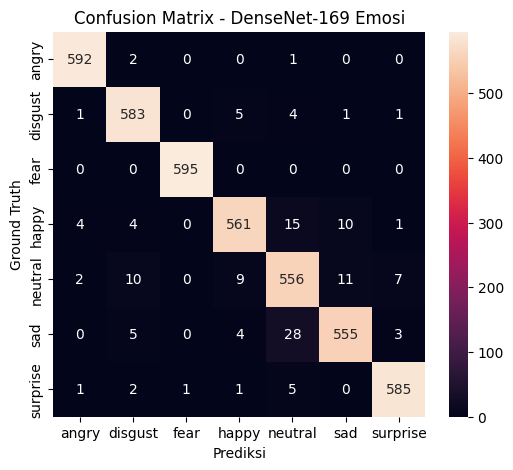

In [17]:
# Load best model
best_model = create_densenet_model(NUM_CLASSES, pretrained=False, freeze_feature_extractor=False)
best_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
best_model.to(device)
best_model.eval()

all_labels = []
all_preds  = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = best_model(imgs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix & classification report
cm = confusion_matrix(all_labels, all_preds)
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prediksi")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix - DenseNet-169 Emosi")
plt.show()

# **Grad-CAM untuk Visualisasi Area Wajah Penting**

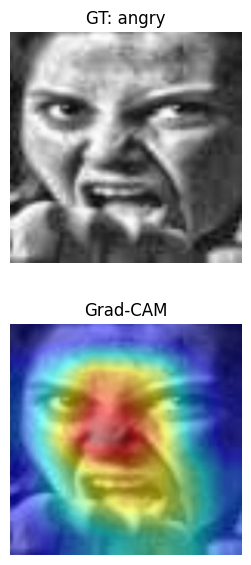

In [20]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def tensor_to_image_np(tensor):
    img = tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C,H,W -> H,W,C
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    return img

# pastikan model di eval mode
best_model.eval()

# Tentukan target layer untuk DenseNet-169
# Kalau ini nanti bermasalah, bisa coba ganti jadi best_model.features.denseblock4
target_layers = [best_model.features[-1]]

# Ambil satu batch dari test loader
test_iter = iter(test_dl)
imgs, labels = next(test_iter)
imgs = imgs.to(device)
labels = labels.to(device)

# Pakai konteks 'with' agar resource GradCAM beres
with GradCAMPlusPlus(model=best_model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=imgs)   # shape: (N, H, W)

plt.figure(figsize=(10, 6))
for i in range(min(4, len(imgs))):
    img_np = tensor_to_image_np(imgs[i])
    grayscale_cam = grayscale_cams[i]        # ambil CAM untuk sampel ke-i
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    plt.subplot(2, 4, i+1)
    plt.imshow(img_np)
    plt.title(f"GT: {idx_to_class[labels[i].item()]}")
    plt.axis("off")

    plt.subplot(2, 4, i+1+4)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis("off")

plt.tight_layout()
plt.show()


# **Demo Inference**

In [21]:
def predict_single_image(img_path):
    bgr = cv2.imread(img_path)
    face_roi = preprocess_and_detect_face(bgr)
    pil_img = Image.fromarray(face_roi)
    img_tensor = transform(pil_img).unsqueeze(0).to(device)

    best_model.eval()
    with torch.no_grad():
        outputs = best_model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        pred_cls = idx_to_class[pred_idx]

    return pred_cls, probs.cpu().numpy()[0]

test_image = example_paths[1]
pred_cls, probs = predict_single_image(test_image)
print("Predicted:", pred_cls)
print("Probabilities:", probs)

Predicted: angry
Probabilities: [9.9999845e-01 4.6492664e-07 2.0815440e-09 3.1203490e-07 5.3315483e-07
 2.5569977e-07 2.7441361e-08]


# **Save Model**

In [22]:
BEST_MODEL_PATH = "/content/drive/MyDrive/PROJECT_EMOSI/models/densenet169_emosi_best.pth"
torch.save(model.state_dict(), BEST_MODEL_PATH)

# **Ringkasan**

## Ringkasan

Pada proyek ini, kami membangun sistem deteksi emosi karyawan dari citra wajah dengan pipeline:

1. **Pengenalan Wajah (Haarcascade)** - mendeteksi dan memotong wajah dari citra.
2. **Konversi Ruang Warna + CLAHE** - meningkatkan kualitas citra wajah melalui konversi ke grayscale dan peningkatan kontras lokal.
3. **Klasifikasi Emosi berbasis CNN (DenseNet-169, transfer learning)** - memetakan citra wajah menjadi label emosi.

Model dievaluasi menggunakan akurasi, F1-score, dan confusion matrix.  
Grad-CAM digunakan untuk memvisualisasikan area wajah yang paling berkontribusi terhadap prediksi emosi.
